In [1]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Import data

In [2]:
df=pd.read_csv('Data-Collisions.csv')

/Users/thanosming/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(194673, 38)

## Features selection

In [4]:
df=df[['SEVERITYCODE','INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','SPEEDING','HITPARKEDCAR','PEDCYLCOUNT']]

In [5]:
df.columns

Index(['SEVERITYCODE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'SPEEDING', 'HITPARKEDCAR', 'PEDCYLCOUNT'],
      dtype='object')

In [6]:
df.dtypes

SEVERITYCODE       int64
INATTENTIONIND    object
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
SPEEDING          object
HITPARKEDCAR      object
PEDCYLCOUNT        int64
dtype: object

## Preprocessing

In [7]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

#### target variable SEVERITYCODE is not balanced and we're making it even

In [8]:
#balance the SEVERITYCODE
df_balanced=pd.concat([df[df['SEVERITYCODE']==2].sample(58188),df[df['SEVERITYCODE']==1].sample(58188,random_state=1)])
df_balanced['SEVERITYCODE'].value_counts()

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64

#### Make all boolean variables to either 1 or 0 for training

In [9]:
#Change all following features to boolean 1/0
df_balanced['SPEEDING']=df_balanced['SPEEDING'].replace({'Y': 1, None: 0})
df_balanced['INATTENTIONIND']=df_balanced['INATTENTIONIND'].replace({'Y': 1, None: 0})
df_balanced['UNDERINFL']=df_balanced['UNDERINFL'].replace({'Y': 1, 'N': 0, '1':1, '0':0})
df_balanced['HITPARKEDCAR']=df_balanced['HITPARKEDCAR'].replace({'Y': 1, 'N': 0})
df_balanced['PEDCYLCOUNT']=df_balanced['PEDCYLCOUNT'].replace({2: 1})

In [10]:
df_balanced[['SPEEDING','INATTENTIONIND','UNDERINFL','HITPARKEDCAR','PEDCYLCOUNT']]

,SPEEDING,INATTENTIONIND,UNDERINFL,HITPARKEDCAR,PEDCYLCOUNT
168175,0,1,0.0,0,0
145487,0,1,0.0,0,0
2748,0,1,0.0,0,0
156529,0,0,0.0,0,0
27386,0,0,0.0,0,0
...,...,...,...,...,...
139109,0,0,0.0,0,0
22076,0,0,0.0,0,0
162883,0,1,0.0,1,0
162005,0,0,0.0,0,0


### Take a look on which Weather, road condition and light condition involved most

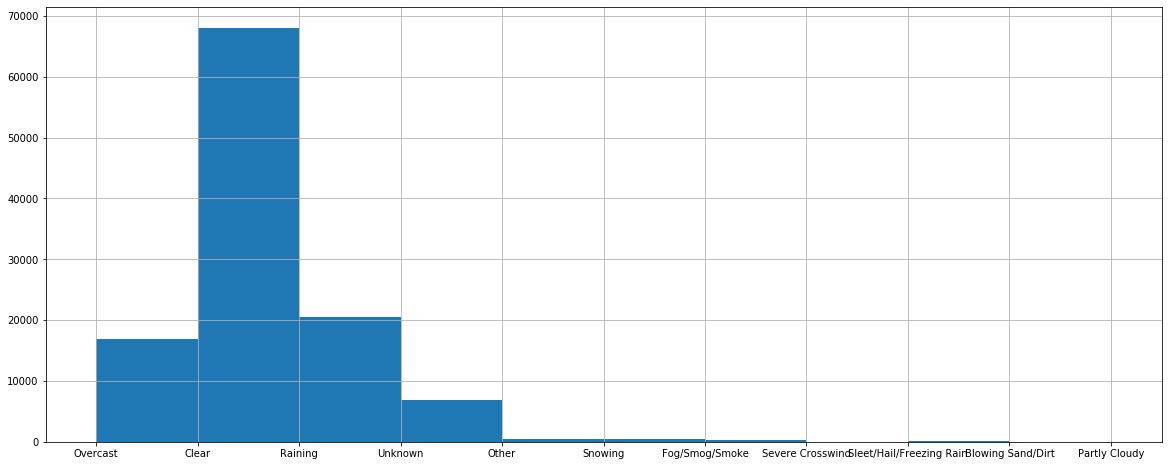

In [11]:
plt.figure(figsize=(20,8))
df_balanced["WEATHER"].hist()

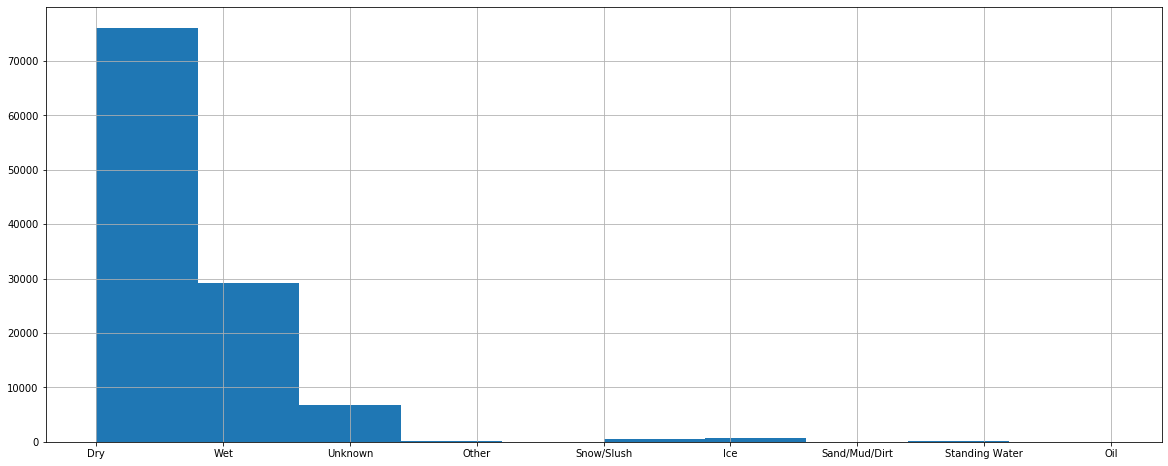

In [12]:
plt.figure(figsize=(20,8))
df_balanced["ROADCOND"].hist()

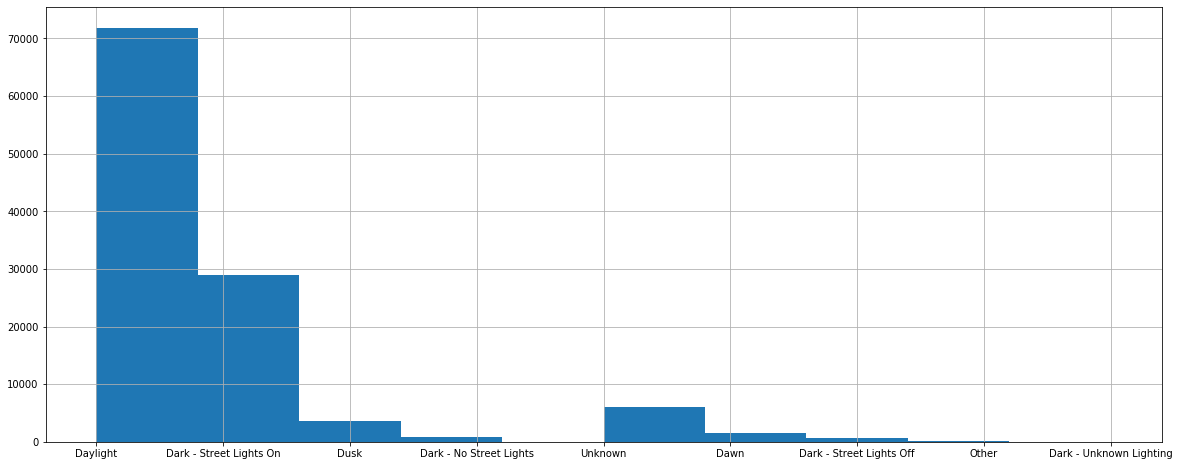

In [13]:
plt.figure(figsize=(20,8))

df_balanced["LIGHTCOND"].hist()

### To train above 3 features, I decided to set dummy variables

In [14]:
#convert to dummy variables

weather=pd.get_dummies(df_balanced['WEATHER'],prefix_sep='_',prefix='WEATHER')
road=pd.get_dummies(df_balanced['ROADCOND'],prefix_sep='_',prefix='ROADCOND')
light=pd.get_dummies(df_balanced['LIGHTCOND'],prefix_sep='_',prefix='LIGHTCOND')

#put back to the dataframe
df_balanced=pd.concat([df_balanced, weather, road, light], axis=1, sort=False)

#remove original columns
df_balanced.drop(columns=['WEATHER', 'ROADCOND', 'LIGHTCOND'], inplace=True)

In [15]:
#check finalized dataframe
df_balanced.columns

Index(['SEVERITYCODE', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING',
       'HITPARKEDCAR', 'PEDCYLCOUNT', 'WEATHER_Blowing Sand/Dirt',
       'WEATHER_Clear', 'WEATHER_Fog/Smog/Smoke', 'WEATHER_Other',
       'WEATHER_Overcast', 'WEATHER_Partly Cloudy', 'WEATHER_Raining',
       'WEATHER_Severe Crosswind', 'WEATHER_Sleet/Hail/Freezing Rain',
       'WEATHER_Snowing', 'WEATHER_Unknown', 'ROADCOND_Dry', 'ROADCOND_Ice',
       'ROADCOND_Oil', 'ROADCOND_Other', 'ROADCOND_Sand/Mud/Dirt',
       'ROADCOND_Snow/Slush', 'ROADCOND_Standing Water', 'ROADCOND_Unknown',
       'ROADCOND_Wet', 'LIGHTCOND_Dark - No Street Lights',
       'LIGHTCOND_Dark - Street Lights Off',
       'LIGHTCOND_Dark - Street Lights On',
       'LIGHTCOND_Dark - Unknown Lighting', 'LIGHTCOND_Dawn',
       'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk', 'LIGHTCOND_Other',
       'LIGHTCOND_Unknown'],
      dtype='object')

## Visualizing data

#### Checking the correlation between features and remove all the highly correlated ones

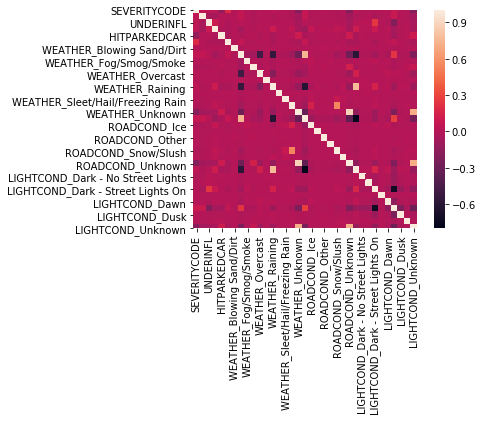

In [16]:
sns.heatmap(df_balanced.corr(),square=True)

### As we can see, some features are showing light colors which implies high correlations, so we remove those

In [17]:
import numpy as np

# Create correlation matrix
corr_matrix = df_balanced.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
print(to_drop)
# Drop features 
df_balanced.drop(to_drop, axis=1, inplace=True)

['ROADCOND_Dry', 'ROADCOND_Unknown', 'ROADCOND_Wet', 'LIGHTCOND_Daylight', 'LIGHTCOND_Unknown']


#### The features shown above will be dropped

### Regraph the corr and check again

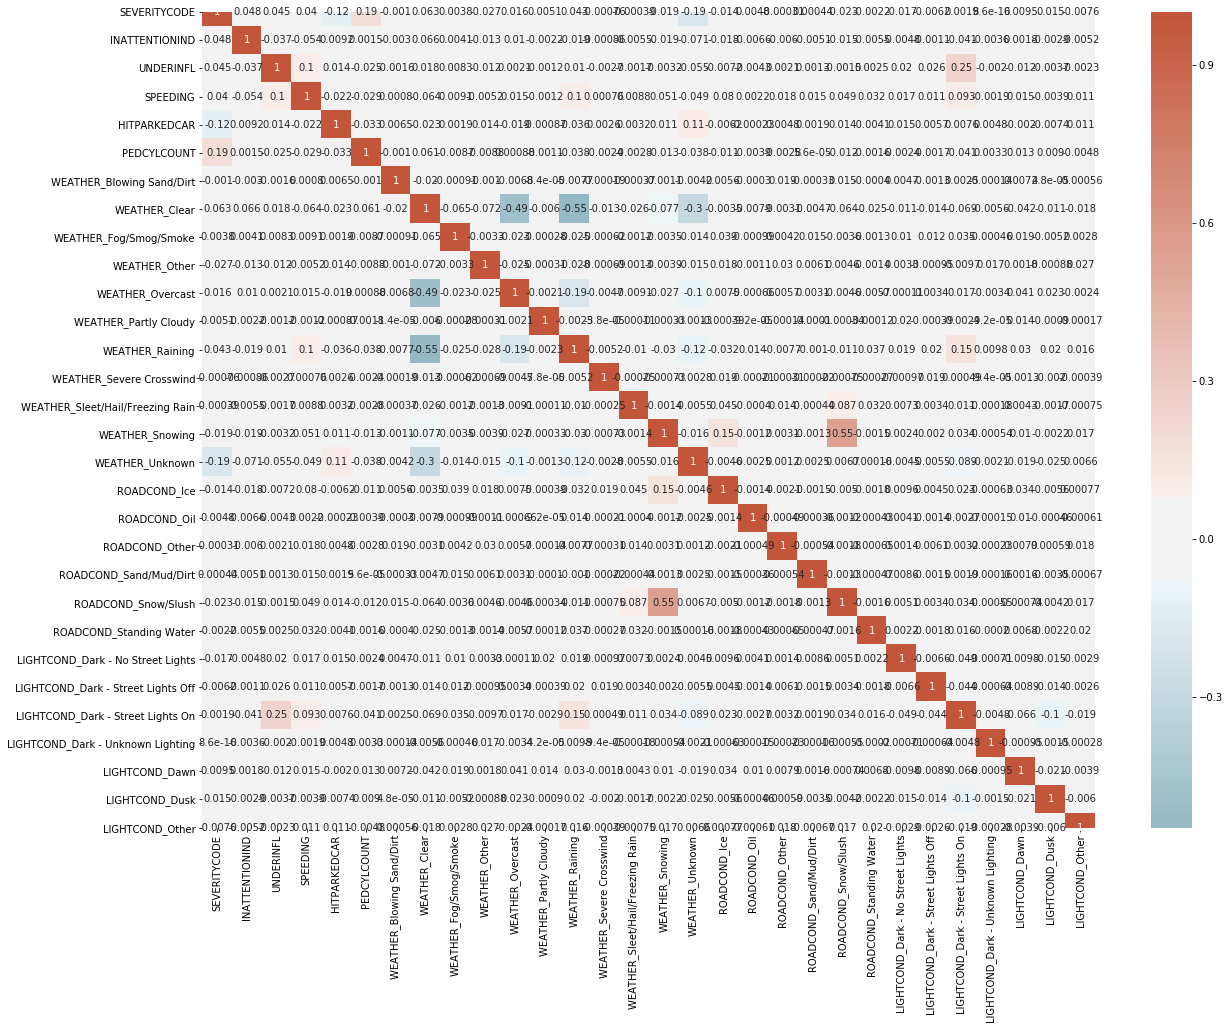

In [18]:
plt.figure(figsize=(20,15))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df_balanced.corr(), annot=True, cmap=cmap, center=0)
plt.show()

### Graphing those boolean variables, we see those don't give much impact on the accidents

<Figure size 1440x1080 with 0 Axes>

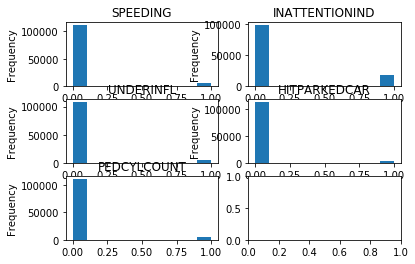

In [19]:
plt.figure(figsize=(20,15))

fig, axes = plt.subplots(3,2)

df_balanced["SPEEDING"].plot(kind='hist',ax=axes[0,0], title="SPEEDING")
df_balanced["INATTENTIONIND"].plot(kind='hist',ax=axes[0,1],title="INATTENTIONIND")
df_balanced["UNDERINFL"].plot(kind='hist',ax=axes[1,0],title="UNDERINFL")
df_balanced["HITPARKEDCAR"].plot(kind='hist',ax=axes[1,1],title="HITPARKEDCAR")
df_balanced["PEDCYLCOUNT"].plot(kind='hist',ax=axes[2,0],title="PEDCYLCOUNT")


In [20]:
print(df_balanced["SPEEDING"].value_counts())
print(df_balanced["INATTENTIONIND"].value_counts())
print(df_balanced["UNDERINFL"].value_counts())
print(df_balanced["HITPARKEDCAR"].value_counts())
print(df_balanced["PEDCYLCOUNT"].value_counts())

0    110341
1      6035
Name: SPEEDING, dtype: int64
0    97621
1    18755
Name: INATTENTIONIND, dtype: int64
0.0    107750
1.0      5947
Name: UNDERINFL, dtype: int64
0    113066
1      3310
Name: HITPARKEDCAR, dtype: int64
0    111271
1      5105
Name: PEDCYLCOUNT, dtype: int64


# Model training

## select features

In [21]:
X=df_balanced.drop('SEVERITYCODE',axis=1)
X=X.fillna(0)
y=df_balanced['SEVERITYCODE'].values


## split 20% test and 80% training set

In [22]:
from sklearn.metrics import jaccard_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
for d in range(1,21):
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth = d).fit(X_train,y_train)
    dtree_yhat=dtree.predict(X_test)
    print("d: {} f1: {} jaccard_score: {}".format(d,f1_score(y_test, dtree_yhat, average = 'weighted'), 
                                                             jaccard_score(y_test, dtree_yhat)))

d: 1 f1: 0.40847806667768033 jaccard_score: 0.5109051009897443
d: 2 f1: 0.4385632157854092 jaccard_score: 0.09957936303545369
d: 3 f1: 0.4709212884298486 jaccard_score: 0.13684389911383776
d: 4 f1: 0.47089247500322784 jaccard_score: 0.13683223992502344
d: 5 f1: 0.5223993715996853 jaccard_score: 0.47755390597384234
d: 6 f1: 0.5590022943247576 jaccard_score: 0.44419950399559105
d: 7 f1: 0.5592211775217999 jaccard_score: 0.4454170107349298
d: 8 f1: 0.5591129117917377 jaccard_score: 0.44539850286217525
d: 9 f1: 0.5642367706656432 jaccard_score: 0.44346083180223816
d: 10 f1: 0.5556624892962527 jaccard_score: 0.29972463461131116
d: 11 f1: 0.5570401397179241 jaccard_score: 0.3029620769717864
d: 12 f1: 0.5567088837284527 jaccard_score: 0.30249085280045035
d: 13 f1: 0.5573287927861706 jaccard_score: 0.3034885356590238
d: 14 f1: 0.557698704855235 jaccard_score: 0.3044608359676853
d: 15 f1: 0.5463142939195251 jaccard_score: 0.2673326375428657
d: 16 f1: 0.5459929871028767 jaccard_score: 0.26693999

# KNN

#### My laptop is not capable to train many ks and thus picked 1, 5, 10 to try out

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


for n in [1,5,10]:
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    print("k: {} f1: {} jaccard_score: {}".format(n,f1_score(y_test, yhat, average = 'weighted'), 
                                                             jaccard_score(y_test, yhat)))

k: 1 f1: 0.5398589935308569 jaccard_score: 0.329738933030647
k: 5 f1: 0.5485826145006429 jaccard_score: 0.3561122367532388
k: 10 f1: 0.5497716625799005 jaccard_score: 0.3291188484730597


## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

C=[1,0.1,0.01]
solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']

for c in C:
    for s in solvers:
        lr_model = LogisticRegression(C = c, solver = s).fit(X_train,y_train)
        lr_yhat=lr_model.predict_proba(X_test)
        print("C: {} solver: {} log_loss: {}".format(c, s, log_loss(y_test, lr_yhat)))


/Users/thanosming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C: 1 solver: lbfgs log_loss: 0.6459427633089113
C: 1 solver: saga log_loss: 0.6459223934788444
C: 1 solver: liblinear log_loss: 0.6459218344849156
C: 1 solver: newton-cg log_loss: 0.6459223419657424
C: 1 solver: sag log_loss: 0.6459224605566929
C: 0.1 solver: lbfgs log_loss: 0.6458427317632932
C: 0.1 solver: saga log_loss: 0.6458439365221829
C: 0.1 solver: liblinear log_loss: 0.6458389230693651
C: 0.1 solver: newton-cg log_loss: 0.645844032269364
C: 0.1 solver: sag log_loss: 0.6458444183070281
C: 0.01 solver: lbfgs log_loss: 0.6464935291642664
C: 0.01 solver: saga log_loss: 0.6464933395329232
C: 0.01 solver: liblinear log_loss: 0.6464646235722713
C: 0.01 solver: newton-cg log_loss: 0.6464938401001202
C: 0.01 solver: sag log_loss: 0.64649544253162
